In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image

In [144]:
dim = 224

train_transform = transforms.Compose([ 
    #####
    # Data Augmentation
    #####
    transforms.ToTensor(),
    transforms.Resize((dim, dim)),   
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((dim, dim)),   
])


In [145]:

# Loading the Datasets CIFAR 10
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [146]:
image, label = next(iter(trainloader))
print(image.shape)

torch.Size([4, 3, 224, 224])


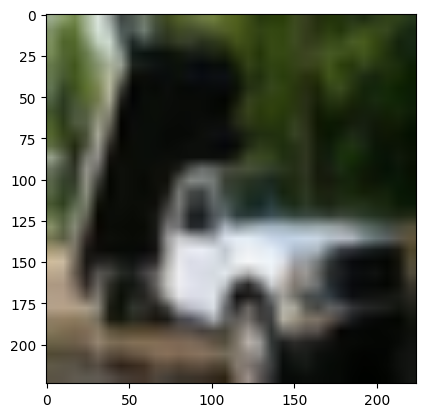

In [147]:
image = image[0].squeeze().permute(1, 2, 0)
plt.imshow(image)
plt.show()

In [148]:
# Creating the Model
num_classes = 10


class Net(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.feature_extract = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*dim*dim//4//4//4, num_classes),
            nn.Linear(num_classes, num_classes)
        )
    def forward(self, x):
        x = self.feature_extract(x)
        x = self.classifier(x)
        return x

In [149]:
model = Net(num_classes)
print(model.parameters)

<bound method Module.parameters of Net(
  (feature_extract): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ELU(alpha=1.0)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
)>


In [150]:

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [151]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

Net(
  (feature_extract): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ELU(alpha=1.0)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [152]:

# Training the Model
num_epochs = 15


for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images , labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Epoch 1, Loss: 1.57822409029603
Epoch 2, Loss: 1.2534596492110193
Epoch 3, Loss: 1.1306566167108714
Epoch 4, Loss: 1.0527512215772272
Epoch 5, Loss: 0.9783454403512553
Epoch 6, Loss: 0.9060852631195635
Epoch 7, Loss: 0.8420041240385361
Epoch 8, Loss: 0.7794228404172603
Epoch 9, Loss: 0.7137409783008366
Epoch 10, Loss: 0.6625536477983464
Epoch 11, Loss: 0.6171616075021028
Epoch 12, Loss: 0.5657907922606614
Epoch 13, Loss: 0.5324787307451087
Epoch 14, Loss: 0.5000758501519835
Epoch 15, Loss: 0.4783813967259018


In [153]:
# Evaluating the Model
from torchmetrics import Accuracy, Precision, Recall

accuracy = Accuracy(task= 'multiclass', num_classes=num_classes, average='macro').to(device)
precision = Precision(task= 'multiclass', num_classes=num_classes, average='macro').to(device)
recall = Recall(task= 'multiclass', num_classes=num_classes, average='macro').to(device)

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        accuracy(outputs, labels)
        precision(outputs, labels)
        recall(outputs, labels)

print(f'Accuracy: {accuracy.compute()}')
print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')

Accuracy: 0.54339998960495
Precision: 0.553722620010376
Recall: 0.54339998960495
